In [1]:
import os
import argparse
import glob
from PIL import Image
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import seaborn as sns

In [29]:
parser = argparse.ArgumentParser()
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--viz', action='store_true')
parser.add_argument('--niters', type=int, default=1000)
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--num_samples', type=int, default=512)
parser.add_argument('--width', type=int, default=64)
parser.add_argument('--hidden_dim', type=int, default=32)
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--train_dir', type=str, default=None)
parser.add_argument('--results_dir', type=str, default="./results_toy_2d")
parser.add_argument('--problem_dim', type=int, default=1)
parser.add_argument('--run_model', type=bool, default=False)
args = parser.parse_args(args=())

In [4]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)

In [5]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [6]:
device = torch.device('cuda:' + str(args.gpu)
                          if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
class CNF(nn.Module):
    """Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.hyper_net = HyperNetwork(in_out_dim, hidden_dim, width)

    def forward(self, t, states):
        z = states[0]
        logp_z = states[1]

        batchsize = z.shape[0]

        with torch.set_grad_enabled(True):
            z.requires_grad_(True)

            W, B, U = self.hyper_net(t)

            Z = torch.unsqueeze(z, 0).repeat(self.width, 1, 1)

            h = torch.tanh(torch.matmul(Z, W) + B)
            dz_dt = torch.matmul(h, U).mean(0)

            dlogp_z_dt = -trace_df_dz(dz_dt, z).view(batchsize, 1)

        return (dz_dt, dlogp_z_dt)


def trace_df_dz(f, z):
    """Calculates the trace of the Jacobian df/dz.
    Stolen from: https://github.com/rtqichen/ffjord/blob/master/lib/layers/odefunc.py#L13
    """
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()

    return sum_diag.contiguous()


class HyperNetwork(nn.Module):
    """Hyper-network allowing f(z(t), t) to change with time.

    Adapted from the NumPy implementation at:
    https://gist.github.com/rtqichen/91924063aa4cc95e7ef30b3a5491cc52
    """
    def __init__(self, in_out_dim, hidden_dim, width):
        super().__init__()

        blocksize = width * in_out_dim

        self.fc1 = nn.Linear(1, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3 * blocksize + width)

        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        self.width = width
        self.blocksize = blocksize

    def forward(self, t):
        # predict params
        params = t.reshape(1, 1)
        params = torch.tanh(self.fc1(params))
        params = torch.tanh(self.fc2(params))
        params = self.fc3(params)

        # restructure
        params = params.reshape(-1)
        W = params[:self.blocksize].reshape(self.width, self.in_out_dim, 1)

        U = params[self.blocksize:2 * self.blocksize].reshape(self.width, 1, self.in_out_dim)

        G = params[2 * self.blocksize:3 * self.blocksize].reshape(self.width, 1, self.in_out_dim)
        U = U * torch.sigmoid(G)

        B = params[3 * self.blocksize:].reshape(self.width, 1, 1)
        return [W, B, U]

In [8]:
def get_batch(num_samples, problem_dim):
    if problem_dim == 2:
        points, _ = make_circles(n_samples=num_samples, noise=0.06, factor=0.5)
        x = torch.tensor(points).type(torch.float32).to(device)
        logp_diff_t1 = torch.zeros(num_samples, 1).type(torch.float32).to(device)
        return(x, logp_diff_t1)
    elif problem_dim == 1:
        # Define the mean of each gaussian
        means = np.array([-3.5, 0.0, 3.5])
        # Define the weights for each gaussian
        weights = np.array([0.2, 0.2, 0.6])
        weights /= np.sum(weights)
        # randomly choose a gaussian for each sample
        components = np.random.choice(means.size, size=num_samples, p=weights)
        # sample from the chosen gaussians
        points = np.random.normal(means[components], 1, size=num_samples)
        return torch.from_numpy(points).float().view(-1, 1).to(device), torch.zeros(num_samples, 1).type(torch.float32).to(device)        

In [9]:
# def get_batch_2(num_samples):
#     # Define the mean of each gaussian
#     means = np.array([-3.5, 0.0, 3.5])
#     # Define the weights for each gaussian
#     weights = np.array([0.2, 0.2, 0.6])
#     weights /= np.sum(weights)
#     # randomly choose a gaussian for each sample
#     components = np.random.choice(means.size, size=num_samples, p=weights)
#     # sample from the chosen gaussians
#     points = np.random.normal(means[components], 1, size=num_samples)
#     return torch.from_numpy(points).float().view(-1, 1).to(device), 
# torch.zeros(num_samples, 1).type(torch.float32).to(device)

In [10]:
# pts, difft1 = get_batch_2(2000)
# sns.histplot(pts, kde=True)

In [11]:
t0 = 0
t1 = 10

In [12]:
if args.problem_dim == 1:
    p_z0 = torch.distributions.Normal(
    loc=torch.tensor(0.0).to(device),
    scale=torch.tensor(1.0).to(device)
        )
    
#     x, logp_diff_t1 = get_batch_2(args.num_samples)
else:
    p_z0 = torch.distributions.MultivariateNormal(
        loc=torch.tensor([0.0, 0.0]).to(device),
        covariance_matrix=torch.tensor([[0.1, 0.0], [0.0, 0.1]]).to(device)
        )
#     x, logp_diff_t1 = get_batch(args.num_samples)

In [13]:
func = CNF(in_out_dim=args.problem_dim, hidden_dim=args.hidden_dim, width=args.width).to(device)
optimizer = optim.Adam(func.parameters(), lr=args.lr)

In [14]:
# z_t, logp_diff_t = odeint(
#                 func,
#                 (x, logp_diff_t1),
#                 torch.tensor([t1, t0]).type(torch.float32).to(device),
#                 atol=1e-5,
#                 rtol=1e-5,
#                 method='dopri5',
#             )

In [15]:
# z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

# if args.problem_dim == 1:
#     logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1)
# else:
#     logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)

In [16]:
# p_z0.log_prob(z_t0).shape

In [17]:
# z_t0.shape # 512, 2

In [18]:
# logp_diff_t0.shape # 512, 1

In [19]:
# logp_diff_t0.view(-1).shape # 512

In [20]:
# logp_x.shape # 512

In [21]:
# loss = -logp_x.mean(0) # single value tensor

In [22]:
# loss

In [33]:
if args.run_model:
    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()

        x, logp_diff_t1 = get_batch(args.num_samples, args.problem_dim)

        z_t, logp_diff_t = odeint(
            func,
            (x, logp_diff_t1),
            torch.tensor([t1, t0]).type(torch.float32).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

        z_t0, logp_diff_t0 = z_t[-1], logp_diff_t[-1]

        if args.problem_dim == 1:
            logp_x = p_z0.log_prob(z_t0).to(device).view(-1) - logp_diff_t0.view(-1)
        else:
            logp_x = p_z0.log_prob(z_t0).to(device) - logp_diff_t0.view(-1)

        loss = -logp_x.mean(0)

        loss.backward()
        optimizer.step()

        #     loss_meter.update(loss.item())

        #     print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss_meter.avg))
        print('Iter: {}, running avg loss: {:.4f}'.format(itr, loss.item()))
else:
    func = CNF(in_out_dim=args.problem_dim, hidden_dim=args.hidden_dim, width=args.width).to(device)
    func.load_state_dict(torch.load("./ffjord_toy_1d.pt"))

In [34]:
func

CNF(
  (hyper_net): HyperNetwork(
    (fc1): Linear(in_features=1, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=256, bias=True)
  )
)

In [30]:
# torch.save(func.state_dict(), "./ffjord_toy_1d.pt")

In [ ]:
#     def plt_flow_1D(prior_logdensity, transform, ax, npts=1000, title="$q(x)$", device="cpu"):
#     z = torch.linspace(LOW, HIGH, npts).unsqueeze(1).to(device)
#     z.requires_grad_(True)
#     logqz = prior_logdensity(z)

#     z0 = z.clone().detach().requires_grad_(True)
#     logqz = transform.forward(0, (z0, logqz))[0].detach()
#     z0 = z0.detach()

#     f, = torch.autograd.grad(logqz.sum(), z0)

#     ax.quiver(z.cpu().numpy(), torch.zeros(npts), f.cpu().numpy(), torch.ones(npts), color='b')
#     ax.set_title(title)

# fig, ax = plt.subplots(1, 1, figsize=(5, 1))
# plt_flow_1D(prior_logdensity, transform, ax)

<Axes: ylabel='Count'>

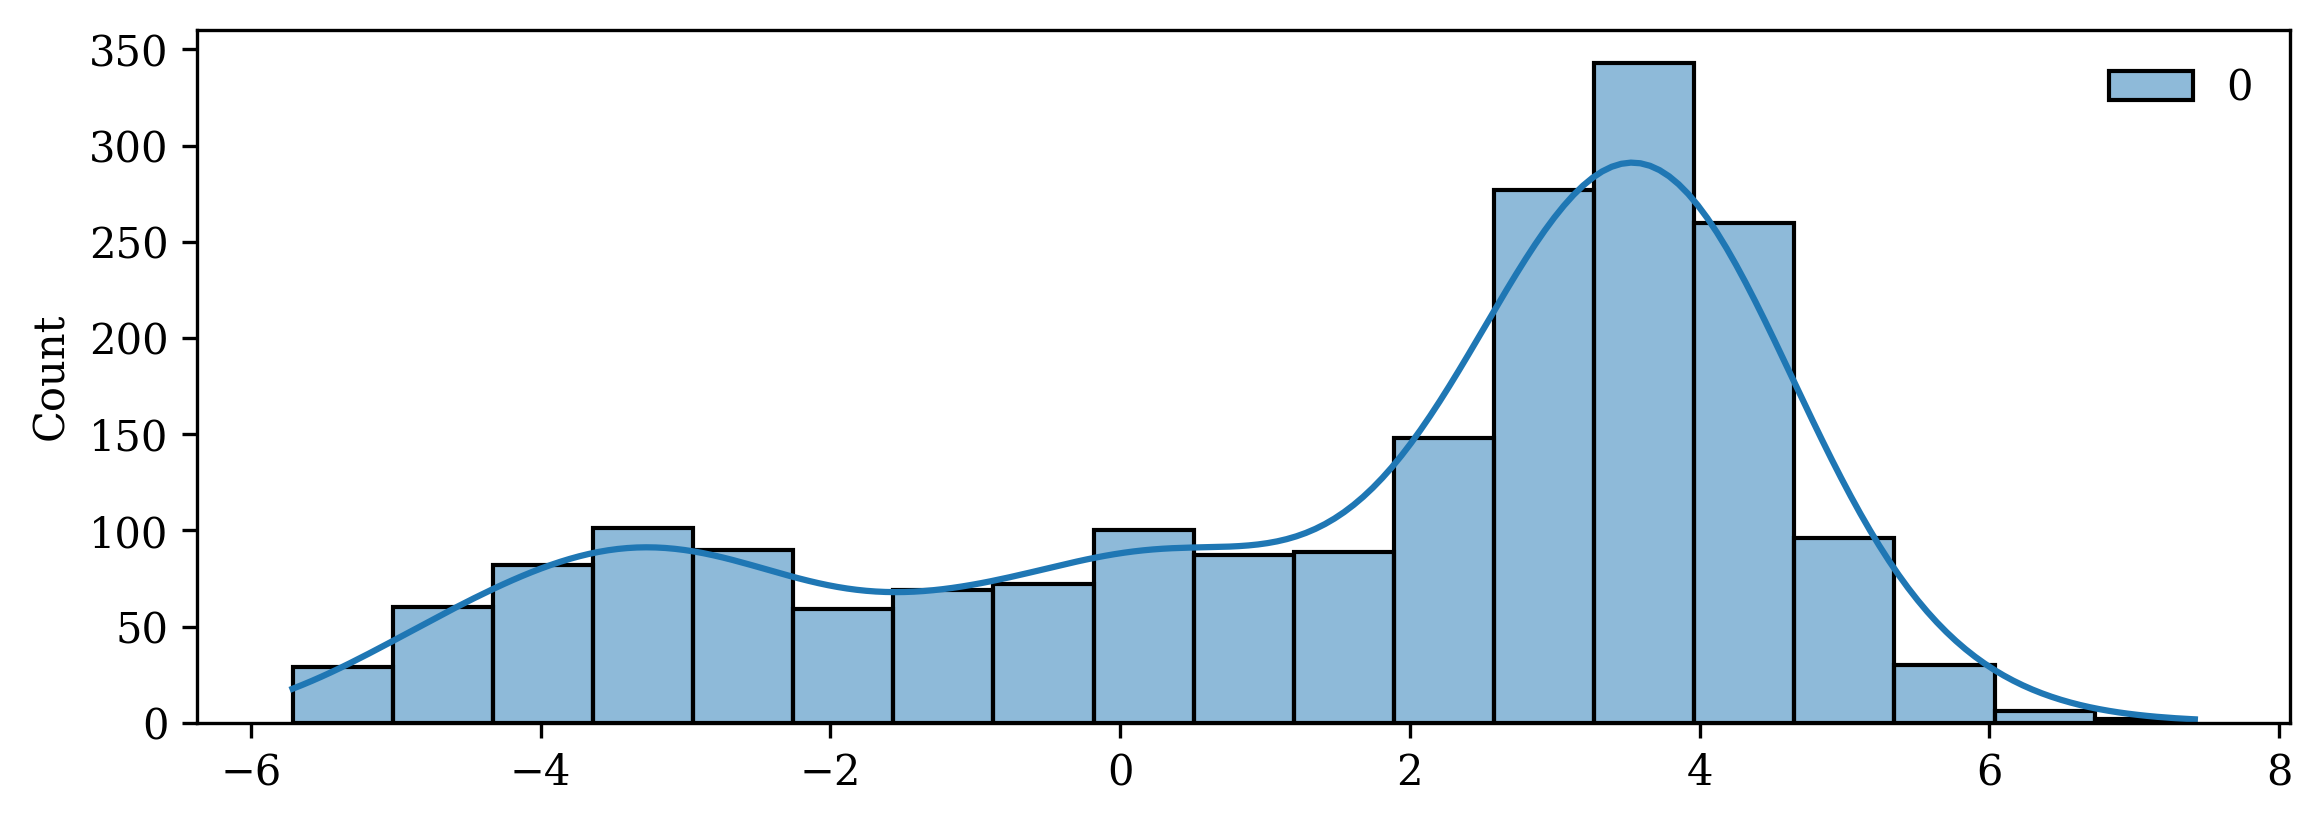

In [28]:
pts, difft1 = get_batch(2000, args.problem_dim)
sns.histplot(pts, kde=True)

In [ ]:
# def visualize_transform(
#     potential_or_samples, prior_sample, prior_density, transform=None, inverse_transform=None, samples=True, npts=100,
#     memory=100, device="cpu"
# ):
#     """Produces visualization for the model density and samples from the model."""
#     plt.clf()
#     ax = plt.subplot(1, 3, 1, aspect="equal")
#     if samples:
#         plt_samples(potential_or_samples, ax, npts=npts)
#     else:
#         plt_potential_func(potential_or_samples, ax, npts=npts)

#     ax = plt.subplot(1, 3, 2, aspect="equal")
#     if inverse_transform is None:
#         plt_flow(prior_density, transform, ax, npts=npts, device=device)
#     else:
#         plt_flow_density(prior_density, inverse_transform, ax, npts=npts, memory=memory, device=device)

#     ax = plt.subplot(1, 3, 3, aspect="equal")
#     if transform is not None:
#         plt_flow_samples(prior_sample, transform, ax, npts=npts, memory=memory, device=device)

In [35]:
# def plt_flow_samples(prior_sample, transform, ax, npts=100, memory=100, title="$x ~ q(x)$", device="cpu"):
#     z = prior_sample(npts * npts, 2).type(torch.float32).to(device)
#     zk = []
#     inds = torch.arange(0, z.shape[0]).to(torch.int64)
#     for ii in torch.split(inds, int(memory**2)):
#         zk.append(transform(z[ii]))
#     zk = torch.cat(zk, 0).cpu().numpy()
#     ax.hist2d(zk[:, 0], zk[:, 1], range=[[LOW, HIGH], [LOW, HIGH]], bins=npts)
#     ax.invert_yaxis()
#     ax.get_xaxis().set_ticks([])
#     ax.get_yaxis().set_ticks([])
#     ax.set_title(title)

In [ ]:
# LOW = -4
# HIGH = 4


# def plt_potential_func(potential, ax, npts=100, title="$p(x)$"):
#     """
#     Args:
#         potential: computes U(z_k) given z_k
#     """
#     xside = np.linspace(LOW, HIGH, npts)
#     yside = np.linspace(LOW, HIGH, npts)
#     xx, yy = np.meshgrid(xside, yside)
#     z = np.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)])

#     z = torch.Tensor(z)
#     u = potential(z).cpu().numpy()
#     p = np.exp(-u).reshape(npts, npts)

#     plt.pcolormesh(xx, yy, p)
#     ax.invert_yaxis()
#     ax.get_xaxis().set_ticks([])
#     ax.get_yaxis().set_ticks([])
#     ax.set_title(title)
